In [1]:
import numpy as np
import collections
from torch.utils import data

import sys
sys.path.append('.')
sys.path.append('../')

from einops import rearrange

import torch
import torch.nn as nn
from torch.nn import functional as FeatureAlphaDropout
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data.dataloader import DataLoader

import math
from torch.utils.data import Dataset

from scipy import io as scipyio
import skimage
import skvideo.io

import os
import glob
parent_path = os.path.dirname(os.path.dirname(os.getcwd())) + "/"
sys.path.append("neuroformer")

In [2]:
# set up logging
import logging
logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s -   %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
)

In [3]:
from utils import set_seed
set_seed(25)

In [4]:
# R3D: (3 x T x H x W)

from SpikeVidUtils import image_dataset

stim_folder = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli"
im_path = ['/Combined Stimuli 3-grating.tif',
           '/Combined Stimuli 3-Movie2.tif',
           '/Combined Stimuli 3-Movie3.tif']

train_path = "/content/stimulus"
train_path = "/Users/antonis/Downloads/OneCombo3/stimuli"
video_stack = [skimage.io.imread(stim_folder + vid) for vid in im_path]
print(glob.glob(train_path + '/*.tif'))
video_stack = np.concatenate(video_stack, axis=0)

# video_stack = skimage.io.imread("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/stimuli/Combined Stimuli 3-grating.tif")
# video_stack = image_dataset(video_stack)
# video_stack = video_stack[::3]  # convert from 60 to 20 fps
# video_stack = video_stack.view(1, video_stack.shape[0], video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])

video_stack = image_dataset(video_stack)
video_stack = video_stack[::3]  # convert from 60 to 20 fps
video_stack = video_stack.view(3, video_stack.shape[0] // 3, video_stack.shape[1], video_stack.shape[2], video_stack.shape[3])
# video_stack = video_stack.transpose(-1, -2)

# rearrange(video_stack[0, 0:2].transpose(0,1), 'c t (h p1) (w p2) -> (t h w) (p1 p2 c)', p1=16, p2=16).shape

[]
im_sack size: torch.Size([5760, 1, 64, 112])


In [5]:
video_stack.shape

torch.Size([3, 640, 1, 64, 112])

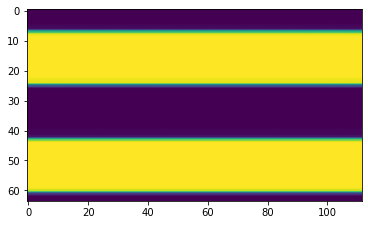

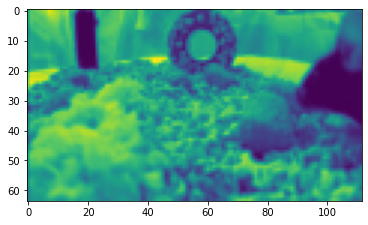

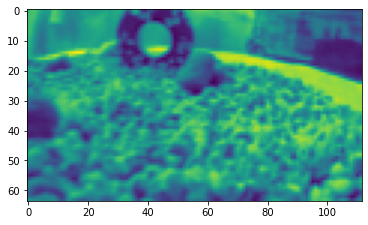

In [6]:
plt.figure()
plt.imshow(video_stack[0, 1, 0].permute(0, 1))
plt.figure()
plt.imshow(video_stack[1, 1, 0].permute(0, 1))
plt.figure()
plt.imshow(video_stack[2, 1, 0].permute(0, 1))

In [7]:
# spike_path = "/home/antonis/projects/slab/git/slab/transformer_exp/code/data/SImNew3D/neural/NatureMoviePart1-A" # "code/data/SImIm/simNeu_3D_WithNorm__Combo3.mat" 
from SpikeVidUtils import trial_df_combo3

spike_data = scipyio.loadmat("/home/antonis/projects/slab/git/slab/transformer_exp/code/data/OneCombo3/spiketrain.mat")
spike_data = np.squeeze(spike_data['spiketrain'].T, axis=-1)
spike_data = [trial_df_combo3(spike_data, n_stim) for n_stim in range(3)]
spike_data = pd.concat(spike_data, axis=0)

spike_data['Trial'] = spike_data['Trial'] + 1
spike_data['Time'] = spike_data['Time'] * 0.0751
spike_data = spike_data[(spike_data['Time'] > 0) & (spike_data['Time'] <= 32)]

# vid_duration = [len(vid) * 1/20 for vid in vid_list]

df = spike_data
del spike_data

In [8]:
# df_sim = pd.read_csv("data/full_sim__model_weighted_shuffle_decay_True_perceiver_2.0_dt_0.05_eos_8_8_256.csv").iloc[1:, 1:].reset_index(drop=True)
# df_sim = df_sim[df_sim['ID'] <= 164]
# df_sim['Trial'] = df_sim['Trial'] + df['Trial'].max()
# df = pd.concat([df, df_sim], axis=0)

In [9]:
# df = pd.read_csv(parent_path + "code/data/OneCombo3/Combo3_all_stim.csv")
window = 0.5
dt = 0.05

from SpikeVidUtils import make_intervals

df['Interval'] = make_intervals(df, window)
# df['Interval_dt'] = make_intervals(df, dt)
# df['Interval_dt'] = (df['Interval_dt'] - df['Interval'] + window).round(3)
df = df.reset_index(drop=True)

In [10]:
# n_dt = sorted((df['Interval_dt'].unique()).round(2)) 
dt_range = int(window / dt) + 1  # add first / last interval for SOS / EOS'
n_dt = [round(dt * n, 2) for n in range(dt_range)]
df['Time'] = df['Time'].round(3)

In [11]:
# df.groupby(['Interval', 'Trial']).size().plot.bar()
# df.groupby(['Interval', 'Trial']).agg(['nunique'])
# df.groupby(['Interval', 'Trial']).size().nlargest(100)

In [12]:
from SpikeVidUtils import SpikeTimeVidData

## qv-vae feats
# frames = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_code_feats-24-05-4x4x4.pt").numpy() + 2
# frame_feats = torch.load(parent_path + "code/data/SImNew3D/stimulus/vq-vae_embed_feats-24-05-4x4x4.pt").numpy()
# frame_block_size = frames.shape[-1] - 1

## resnet3d feats
frame_feats = video_stack.transpose(1, 2)

frame_block_size = 560
prev_id_block_size = 52
id_block_size = 52   # 95
block_size = frame_block_size + id_block_size + prev_id_block_size # frame_block_size * 2  # small window for faster training
frame_memory = 20   # how many frames back does model see
window = window

neurons = sorted(list(set(df['ID'])))
id_stoi = { ch:i for i,ch in enumerate(neurons) }
id_itos = { i:ch for i,ch in enumerate(neurons) }

# translate neural embeddings to separate them from ID embeddings
# frames = frames + [*id_stoi.keys()][-1] 
neurons = [i for i in range(df['ID'].min(), df['ID'].max() + 1)]
# pixels = sorted(np.unique(frames).tolist())
feat_encodings = neurons + ['SOS'] + ['EOS'] + ['PAD']  # + pixels 
stoi = { ch:i for i,ch in enumerate(feat_encodings) }
itos = { i:ch for i,ch in enumerate(feat_encodings) }
stoi_dt = { ch:i for i,ch in enumerate(n_dt) }
itos_dt = { i:ch for i,ch in enumerate(n_dt) }
max(list(itos_dt.values()))

0.5

In [13]:
# train_len = round(len(df)*(4/5))
# test_len = round(len(df) - train_len)

# train_data = df[:train_len]
# test_data = df[train_len:train_len + test_len].reset_index().drop(['index'], axis=1)

n = []
for n_stim in range(df['Trial'].max() // 20):
    n_trial = [3, 15, 5, 18]
    for n_trial in n_trial:
        trial = (n_stim + 1) * 20 - n_trial
        n.append(trial)
train_data = df[~df['Trial'].isin(n)].reset_index(drop=True)
test_data = df[df['Trial'].isin(n)].reset_index(drop=True)
small_data = df[df['Trial'].isin([5])].reset_index(drop=True)

In [14]:
from SpikeVidUtils import SpikeTimeVidData2

# train_dat1aset = spikeTimeData(spikes, block_size, dt, stoi, itos)

train_dataset = SpikeTimeVidData2(train_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
test_dataset = SpikeTimeVidData2(test_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)
# dataset = SpikeTimeVidData(df, frames, frame_feats, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos)
# single_batch = SpikeTimeVidData(df[df['Trial'].isin([5])], None, block_size, frame_block_size, prev_id_block_size, window, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats)
small_dataset = SpikeTimeVidData2(small_data, None, block_size, id_block_size, frame_block_size, prev_id_block_size, window, dt, frame_memory, stoi, itos, neurons, stoi_dt, itos_dt, frame_feats, pred=False)


print(f'train: {len(train_dataset)}, test: {len(test_dataset)}')

Length: 20449 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 5163 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
Length: 393 Neurons: 168 Pixels: 0.
id block size: 52
frames: 560, id: 52
train: 2941, test: 729


In [15]:
iterable = iter(test_dataset)

In [16]:
x, y = next(iterable)

In [17]:
x['id']

tensor([165, 150,  47,  57,  23, 149,  13, 157, 156, 112,  26, 166, 167, 167,
        167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
        167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
        167, 167, 167, 167, 167, 167, 167, 167, 167, 167])

In [18]:
x['id_prev']

tensor([165, 166, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
        167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
        167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167, 167,
        167, 167, 167, 167, 167, 167, 167, 167, 167, 167])

In [19]:
x['id'].size()

torch.Size([52])

In [20]:
x['id'].size() == x['id_prev'].size()

True

In [21]:
x['id_prev'].size()

torch.Size([52])

In [22]:
def get_class_weights(dataset):
  dt = []
  id = []
  for x, y in dataset:
    id.extend([stoi['SOS']] + y['id'][:len(y['id']) - x['pad']].flatten().tolist() + [stoi['PAD']]) # -1 in pad to include PAD token
    dt.extend([stoi_dt[0]] + y['dt'][:len(y['dt']) - x['pad']].flatten().tolist() + [dataset.dt_max]) # -1 in pad to include PAD token

  id = pd.DataFrame(id)
  dt = pd.DataFrame(dt)

  id_freq = id.groupby([0]).size()
  dt_freq = dt.groupby([0]).size()

  id_ones = np.ones(dataset.id_population_size)
  dt_ones = np.ones(dataset.dt_population_size)

  id_ones[id_freq.index] = (1 / id_freq) * id_freq.max() / id_freq.max()
  dt_ones[dt_freq.index] = (1 / dt_freq) * dt_freq.max() / dt_freq.max()
  
  class_freq = dict()
  class_freq['id'] = torch.tensor(id_ones, dtype=torch.float32)
  class_freq['dt'] = torch.tensor(dt_ones, dtype=torch.float32)
  
  return class_freq 

class_weights = get_class_weights(train_dataset)

In [23]:
from model_neuroformer import GPT, GPTConfig, neuralGPTConfig, Decoder
# initialize config class and model (holds hyperparameters)
mconf = GPTConfig(train_dataset.population_size, block_size,    # frame_block_size
                        id_vocab_size=train_dataset.id_population_size,
                        frame_block_size=frame_block_size,
                        id_block_size=id_block_size,  # frame_block_size
                        prev_id_block_size=prev_id_block_size,
                        sparse_mask=False, p_sparse=0.25,
                        n_dt=len(n_dt),
                        data_size=train_dataset.size,
                        class_weights=class_weights,
                        pretrain=False,
                        n_state_layers=2, n_state_history_layers=4, n_stimulus_layers=8,
                        n_head=8, n_embd=256,
                        temp_emb=True, pos_emb=False,
                        id_drop=0.2, im_drop=0.2)
model = GPT(mconf)
# model.load_state_dict(torch.load("/home/antonis/projects/slab/git/neuroformer/models/neuroformer:False_perceiver_2.0_dt:0.05_eos_(4, 4, 8)_8_256.pt", map_location='cpu'))

01/31/2022 20:31:25 - INFO - model_neuroformer -   number of parameters: 1.135590e+07


In [24]:
# model.load_state_dict(torch.load("/content/drive/MyDrive/slab/models/OneCombo3/model_8_4_256.pt"))

In [25]:
# loader = DataLoader(small_dataset, shuffle=False, pin_memory=False,
#                                   batch_size=1, num_workers=1)
# x, y = next(iter(loader))
# model = model.to('cpu')

# preds, features, loss = model(x, y)

In [26]:
from trainer import Trainer, TrainerConfig
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-01-21-14:18-e:19-b:239-l:4-h:2-ne:512-higher_order.pt"))
# model.load_state_dict(torch.load(parent_path +  "code/transformer_vid3/runs/models/12-14-21-23:44-e:17-b:650-l:8-h:4-ne:256-higher_order.pt"))

layers = (mconf.n_state_layers, mconf.n_state_history_layers, mconf.n_stimulus_layers)
max_epochs = 400
batch_size = 32 * 6
shuffle = True
tconf = TrainerConfig(max_epochs=max_epochs, batch_size=batch_size, learning_rate=8e-5, 
                      num_workers=4, lr_decay=True, patience=5, warmup_tokens=4e5, 
                      decay_weights=True, shuffle=shuffle,
                      final_tokens=len(train_dataset)*(block_size // 8) * (max_epochs),
                      clip_norm=1.0, grad_norm_clip=2.0,
                      dataset='higher_order', mode='predict',
                      block_size=train_dataset.block_size,
                      id_block_size=train_dataset.id_block_size,
                      show_grads=False, plot_raster=False,
                      ckpt_path=f"/home/antonis/projects/slab/git/neuroformer/models/neuroformer_unweighted_:{shuffle}_perceiver_2.0_dt:{dt}_eos_{layers}_{mconf.n_head}_{mconf.n_embd}.pt")
# f"/home/antonis/projects/slab/git/neuroformer/models/model_sim_weighted_shuffle_decay:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.pt")

trainer = Trainer(model, train_dataset, test_dataset, tconf, mconf)
trainer.train()  

epoch 1  id_train: 2.52382  time_train: 1.20155  total_loss: 3.72537 lr 2.995200e-05: 100%|██████████| 16/16 [00:04<00:00,  3.28it/s]
01/31/2022 20:31:33 - INFO - trainer -   id_test: 2.45929    time_test: 1.15516  total_loss: 3.61445
01/31/2022 20:31:33 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/neuroformer_unweighted_:True_perceiver_2.0_dt:0.05_eos_(2, 4, 8)_8_256.pt
epoch 2  id_train: 2.36056  time_train: 1.13079  total_loss: 3.49135 lr 6.053840e-05: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
01/31/2022 20:31:38 - INFO - trainer -   id_test: 2.33296    time_test: 1.13486  total_loss: 3.46782
01/31/2022 20:31:38 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/neuroformer_unweighted_:True_perceiver_2.0_dt:0.05_eos_(2, 4, 8)_8_256.pt
epoch 3  id_train: 2.30159  time_train: 1.12046  total_loss: 3.42205 lr 7.914400e-05: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
01/31/2022 20:31:44 - INFO - trainer -   id_test: 

Epoch    48: reducing learning rate of group 0 to 2.3743e-05.
Epoch    48: reducing learning rate of group 1 to 2.3743e-05.


epoch 49  id_train: 2.06203  time_train: 0.85009  total_loss: 2.91212 lr 2.374320e-05: 100%|██████████| 16/16 [00:04<00:00,  3.40it/s]
01/31/2022 20:36:01 - INFO - trainer -   id_test: 2.09466    time_test: 0.82845  total_loss: 2.92311
01/31/2022 20:36:01 - INFO - trainer -   saving /home/antonis/projects/slab/git/neuroformer/models/neuroformer_unweighted_:True_perceiver_2.0_dt:0.05_eos_(2, 4, 8)_8_256.pt
epoch 50  id_train: 2.10769  time_train: 0.78205  total_loss: 2.88974 lr 2.374320e-05: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
01/31/2022 20:36:06 - INFO - trainer -   id_test: 2.11551    time_test: 0.81513  total_loss: 2.93064
epoch 51  id_train: 2.01234  time_train: 0.79036  total_loss: 2.80270 lr 2.374320e-05: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
01/31/2022 20:36:12 - INFO - trainer -   id_test: 2.12763    time_test: 0.82660  total_loss: 2.95423
epoch 52  id_train: 2.08830  time_train: 0.80489  total_loss: 2.89318 lr 2.374320e-05: 100%|██████████| 16/16 [00:04<00

Epoch    55: reducing learning rate of group 0 to 7.1230e-06.
Epoch    55: reducing learning rate of group 1 to 7.1230e-06.


epoch 56  id_train: 2.10525  time_train: 0.79172  total_loss: 2.89696 lr 7.122960e-06: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
01/31/2022 20:36:40 - INFO - trainer -   id_test: 2.10962    time_test: 0.84934  total_loss: 2.95896
epoch 57  id_train: 2.06086  time_train: 0.82416  total_loss: 2.88502 lr 7.122960e-06: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]
01/31/2022 20:36:45 - INFO - trainer -   id_test: 2.12282    time_test: 0.82139  total_loss: 2.94421
epoch 58  id_train: 2.08966  time_train: 0.82948  total_loss: 2.91914 lr 7.122960e-06: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
01/31/2022 20:36:51 - INFO - trainer -   id_test: 2.11809    time_test: 0.81434  total_loss: 2.93243
epoch 59  id_train: 2.07065  time_train: 0.80931  total_loss: 2.87996 lr 7.122960e-06: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
01/31/2022 20:36:56 - INFO - trainer -   id_test: 2.11804    time_test: 0.83770  total_loss: 2.95574
epoch 60  id_train: 2.03006  time_train: 0.81920  total_

Epoch    66: reducing learning rate of group 0 to 2.1369e-06.
Epoch    66: reducing learning rate of group 1 to 2.1369e-06.


epoch 67  id_train: 2.07742  time_train: 0.80435  total_loss: 2.88177 lr 2.136888e-06: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
01/31/2022 20:37:41 - INFO - trainer -   id_test: 2.09550    time_test: 0.82767  total_loss: 2.92318
epoch 68  id_train: 2.08134  time_train: 0.81530  total_loss: 2.89664 lr 2.136888e-06: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
01/31/2022 20:37:46 - INFO - trainer -   id_test: 2.11399    time_test: 0.82531  total_loss: 2.93930
epoch 69  id_train: 2.07899  time_train: 0.80690  total_loss: 2.88589 lr 2.136888e-06: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
01/31/2022 20:37:52 - INFO - trainer -   id_test: 2.12299    time_test: 0.82854  total_loss: 2.95154
epoch 70  id_train: 2.05069  time_train: 0.82005  total_loss: 2.87074 lr 2.136888e-06: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
01/31/2022 20:37:57 - INFO - trainer -   id_test: 2.15826    time_test: 0.82760  total_loss: 2.98586
epoch 71  id_train: 2.12737  time_train: 0.79660  total_

Epoch    72: reducing learning rate of group 0 to 6.4107e-07.
Epoch    72: reducing learning rate of group 1 to 6.4107e-07.


epoch 73  id_train: 2.12123  time_train: 0.81303  total_loss: 2.93426 lr 6.410664e-07: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
01/31/2022 20:38:14 - INFO - trainer -   id_test: 2.09139    time_test: 0.83455  total_loss: 2.92594
epoch 74  id_train: 2.09451  time_train: 0.78724  total_loss: 2.88175 lr 6.410664e-07: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
01/31/2022 20:38:20 - INFO - trainer -   id_test: 2.15221    time_test: 0.82221  total_loss: 2.97442
epoch 75  id_train: 2.08731  time_train: 0.83782  total_loss: 2.92513 lr 6.410664e-07: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
01/31/2022 20:38:25 - INFO - trainer -   id_test: 2.11281    time_test: 0.83371  total_loss: 2.94652
epoch 76  id_train: 2.11294  time_train: 0.77752  total_loss: 2.89046 lr 6.410664e-07: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
01/31/2022 20:38:31 - INFO - trainer -   id_test: 2.15195    time_test: 0.81836  total_loss: 2.97031
epoch 77  id_train: 2.08853  time_train: 0.83327  total_

Epoch    78: reducing learning rate of group 0 to 1.9232e-07.
Epoch    78: reducing learning rate of group 1 to 1.9232e-07.


epoch 79  id_train: 2.11765  time_train: 0.82115  total_loss: 2.93880 lr 1.923199e-07: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
01/31/2022 20:38:47 - INFO - trainer -   id_test: 2.08954    time_test: 0.82700  total_loss: 2.91654
epoch 80  id_train: 2.10903  time_train: 0.80445  total_loss: 2.91348 lr 1.923199e-07: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
01/31/2022 20:38:53 - INFO - trainer -   id_test: 2.10542    time_test: 0.82896  total_loss: 2.93438
epoch 81  id_train: 2.07485  time_train: 0.81287  total_loss: 2.88772 lr 1.923199e-07: 100%|██████████| 16/16 [00:04<00:00,  3.44it/s]
01/31/2022 20:38:58 - INFO - trainer -   id_test: 2.12299    time_test: 0.84333  total_loss: 2.96632
epoch 82  id_train: 2.06628  time_train: 0.79734  total_loss: 2.86362 lr 1.923199e-07: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
01/31/2022 20:39:04 - INFO - trainer -   id_test: 2.06780    time_test: 0.83076  total_loss: 2.89856
01/31/2022 20:39:04 - INFO - trainer -   saving /home/an

Epoch    84: reducing learning rate of group 0 to 5.7696e-08.
Epoch    84: reducing learning rate of group 1 to 5.7696e-08.


epoch 85  id_train: 2.08629  time_train: 0.81162  total_loss: 2.89791 lr 5.769598e-08: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
01/31/2022 20:39:20 - INFO - trainer -   id_test: 2.07650    time_test: 0.83539  total_loss: 2.91190
epoch 86  id_train: 2.06645  time_train: 0.81033  total_loss: 2.87679 lr 5.769598e-08: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
01/31/2022 20:39:26 - INFO - trainer -   id_test: 2.13254    time_test: 0.81953  total_loss: 2.95207
epoch 87  id_train: 2.04312  time_train: 0.81951  total_loss: 2.86263 lr 5.769598e-08: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
01/31/2022 20:39:31 - INFO - trainer -   id_test: 2.09663    time_test: 0.82545  total_loss: 2.92209
epoch 88  id_train: 2.15099  time_train: 0.80970  total_loss: 2.96069 lr 5.769598e-08: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
01/31/2022 20:39:37 - INFO - trainer -   id_test: 2.10680    time_test: 0.82923  total_loss: 2.93603
epoch 89  id_train: 2.12489  time_train: 0.82184  total_

Epoch    90: reducing learning rate of group 0 to 1.7309e-08.
Epoch    90: reducing learning rate of group 1 to 1.7309e-08.


epoch 91  id_train: 2.13329  time_train: 0.78791  total_loss: 2.92120 lr 1.730879e-08: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
01/31/2022 20:39:54 - INFO - trainer -   id_test: 2.08887    time_test: 0.83602  total_loss: 2.92490
epoch 92  id_train: 2.13648  time_train: 0.81822  total_loss: 2.95469 lr 1.730879e-08: 100%|██████████| 16/16 [00:04<00:00,  3.45it/s]
01/31/2022 20:39:59 - INFO - trainer -   id_test: 2.11115    time_test: 0.82761  total_loss: 2.93876
epoch 93  id_train: 2.11507  time_train: 0.80338  total_loss: 2.91845 lr 1.730879e-08: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
01/31/2022 20:40:05 - INFO - trainer -   id_test: 2.13732    time_test: 0.81993  total_loss: 2.95725
epoch 94  id_train: 2.13576  time_train: 0.81517  total_loss: 2.95093 lr 1.730879e-08: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
01/31/2022 20:40:10 - INFO - trainer -   id_test: 2.10634    time_test: 0.80841  total_loss: 2.91476
epoch 95  id_train: 2.05827  time_train: 0.79440  total_

Epoch    96: reducing learning rate of group 0 to 5.1926e-09.
Epoch    96: reducing learning rate of group 1 to 5.1926e-09.


epoch 97  id_train: 2.13400  time_train: 0.79182  total_loss: 2.92582 lr 5.192638e-09: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
01/31/2022 20:40:27 - INFO - trainer -   id_test: 2.11045    time_test: 0.81581  total_loss: 2.92626
epoch 98  id_train: 2.07332  time_train: 0.81411  total_loss: 2.88743 lr 5.192638e-09: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
01/31/2022 20:40:32 - INFO - trainer -   id_test: 2.08038    time_test: 0.83494  total_loss: 2.91532
epoch 99  id_train: 2.15883  time_train: 0.80149  total_loss: 2.96032 lr 5.192638e-09: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
01/31/2022 20:40:38 - INFO - trainer -   id_test: 2.08840    time_test: 0.83571  total_loss: 2.92411
epoch 100  id_train: 2.00306  time_train: 0.82136  total_loss: 2.82442 lr 5.192638e-09: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
01/31/2022 20:40:43 - INFO - trainer -   id_test: 2.11753    time_test: 0.83110  total_loss: 2.94863
epoch 101  id_train: 2.06966  time_train: 0.82420  tota

KeyboardInterrupt: 

In [ ]:
loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=4, num_workers=1)
                                  

In [ ]:
iterable = iter(loader)

In [ ]:
x, y = next(iterable)

In [ ]:
model = model.to('cpu')
preds, features, loss = model(x)

In [ ]:
preds['id'].shape

In [ ]:
x['pad'].shape

In [ ]:
x['id_prev']

In [ ]:
x['id']

In [ ]:
x.keys()

In [ ]:
x['trial'].shape

In [ ]:
x['id']

In [ ]:
x['id_prev']

In [27]:
""" Predict using TEST dataset """

from utils import predict_raster, predict_raster_resnet, predict_raster_enc_dec, predict_raster_recursive, predict_beam_search, predict_raster_recursive_time, predict_raster_recursive_time_auto, predict_beam_search_time, predict_raster_hungarian
from utils import set_plot_params
set_plot_params()
%matplotlib inline

loader = DataLoader(test_dataset, shuffle=False, pin_memory=False,
                                  batch_size=1, num_workers=1)

# device = torch.cuda.current_device()
# model = model.to(device)
model.load_state_dict(torch.load("/home/antonis/projects/slab/git/neuroformer/models/neuroformer_unweighted_:True_perceiver_2.0_dt:0.05_eos_(2, 4, 8)_8_256.pt"))

""" 

To predict only neurons we pass <frame_end> so we see predictions only for Neurons 
If you want to also see frame_tokens, just pass <frame_end=0>

NOTE: 512 ID is the <end-of-sequence-id>. Right now, makes no difference if I include
it in loss, here it is included in loss and predictions.

"""
# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted, true_timing, predicted_timing = predict_time_raster(model, loader, 
#                                                                     f_block_sz=frame_block_size, id_block_sz=frame_block_size, 
#                                                                     get_dt=True)

# true, predicted = predict_raster(model, loader)

# true, predicted = predict_beam_search(model, loader, stoi, frame_end=0)
# true, predicted, true_timing = predict_raster_recursive(model, loader, stoi, sample=True, top_p=0.95, gpu=True, frame_end=0)
results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.95, top_p_t=0.95, temp=1.0, frame_end=0, get_dt=True, gpu=False)

# true, predicted = predict_raster_hungarian(model, loader)
# true, predicted = predict_raster(model, loader, gpu=True)

# true_df = pd.DataFrame(true.numpy())
# predicted_df = pd.DataFrame(predicted.numpy())
# print(len(true_df[true_df[0] == 512]), len(predicted_df[predicted_df[0] == 512])) 

100%|██████████| 729/729 [01:01<00:00, 11.84it/s]


In [28]:
# results = predict_raster_recursive_time_auto(model, loader, window, stoi, itos_dt, sample=True, top_p=0.95, top_p_t=0.95, frame_end=0, get_dt=True, gpu=False)

pred_keys = ['pred', 'time_pred', 'trial', 'interval']
predicted_dict = {k: results[k] for k in results if k in pred_keys}
df_pred = pd.DataFrame(predicted_dict)
df_pred.rename({'pred':'ID', 'time_pred':'dt', 'trial':'Trial'}, axis=1, inplace=True)
df_pred['Time'] = df_pred['dt'] + df_pred['interval'] - 0.5
# df_true['time'] = df_true['dt'] + df_true['interval'] - 0.5

In [29]:
true_keys = ['true', 'time']
true_dict = {k: results[k] for k in results if k in true_keys}
df_true = pd.DataFrame(true_dict)
df_true.rename({'true':'ID', 'Time':'dt'}, axis=1, inplace=True)

In [30]:
# # predicted_timing = [itos_dt[int(dt)] for dt in predicted_timing]
# # df_pred = pd.DataFrame({'True':true, 'Predicted':predicted, 'Time':true_timing, 'Predicted_Time':predicted_timing})    # Time':test_data['Time']})
# df_pred.to_csv(f"/content/drive/MyDrive/slab/predictions/OneCombo3/model_weighted_shuffle:{shuffle}_perceiver_2.0_dt:{dt}_eos_{mconf.n_layer}_{mconf.n_head}_{mconf.n_embd}.csv")

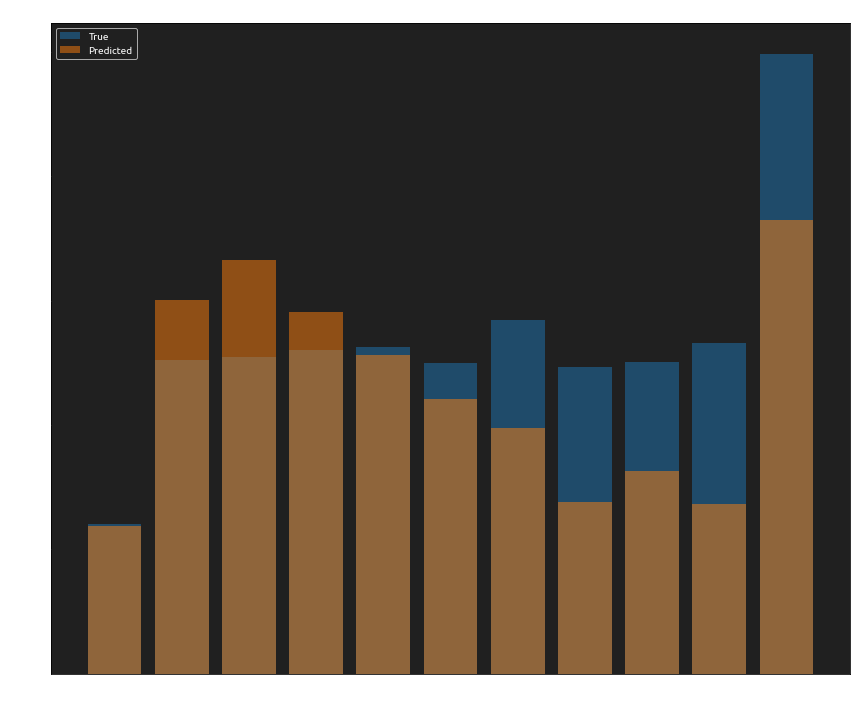

In [34]:
# df_dt = [y['dt'][:len(y['dt']) - (x['pad'])] for x, y in test_dataset]
plt.figure(figsize=(12,10))

# df_dt = df_true['time']
freq_dt_true = df_true.groupby(['time']).size()
plt.bar(np.arange(len(freq_dt_true.index)), freq_dt_true, alpha=0.5, label='True')


# df_dt_pred = df_pred['time_pred']
freq_dt_pred = df_pred.groupby(['dt']).size()
plt.bar(np.arange(len(freq_dt_pred.index)), freq_dt_pred, alpha=0.5, label='Predicted')


# plt.xticks(ticks=pd.to_numeric(freq_dt_pred.index)labels=pd.to_numeric(freq_dt_pred.index))
plt.title('dt Interval Groups')
plt.xlabel('dt Group (n x 0.05s)')
plt.ylabel('Count (N)')

plt.legend()

plt.tight_layout()
# plt.savefig("dt_interval_dist.png", dpi=300)


In [32]:
len(df_pred)

5039

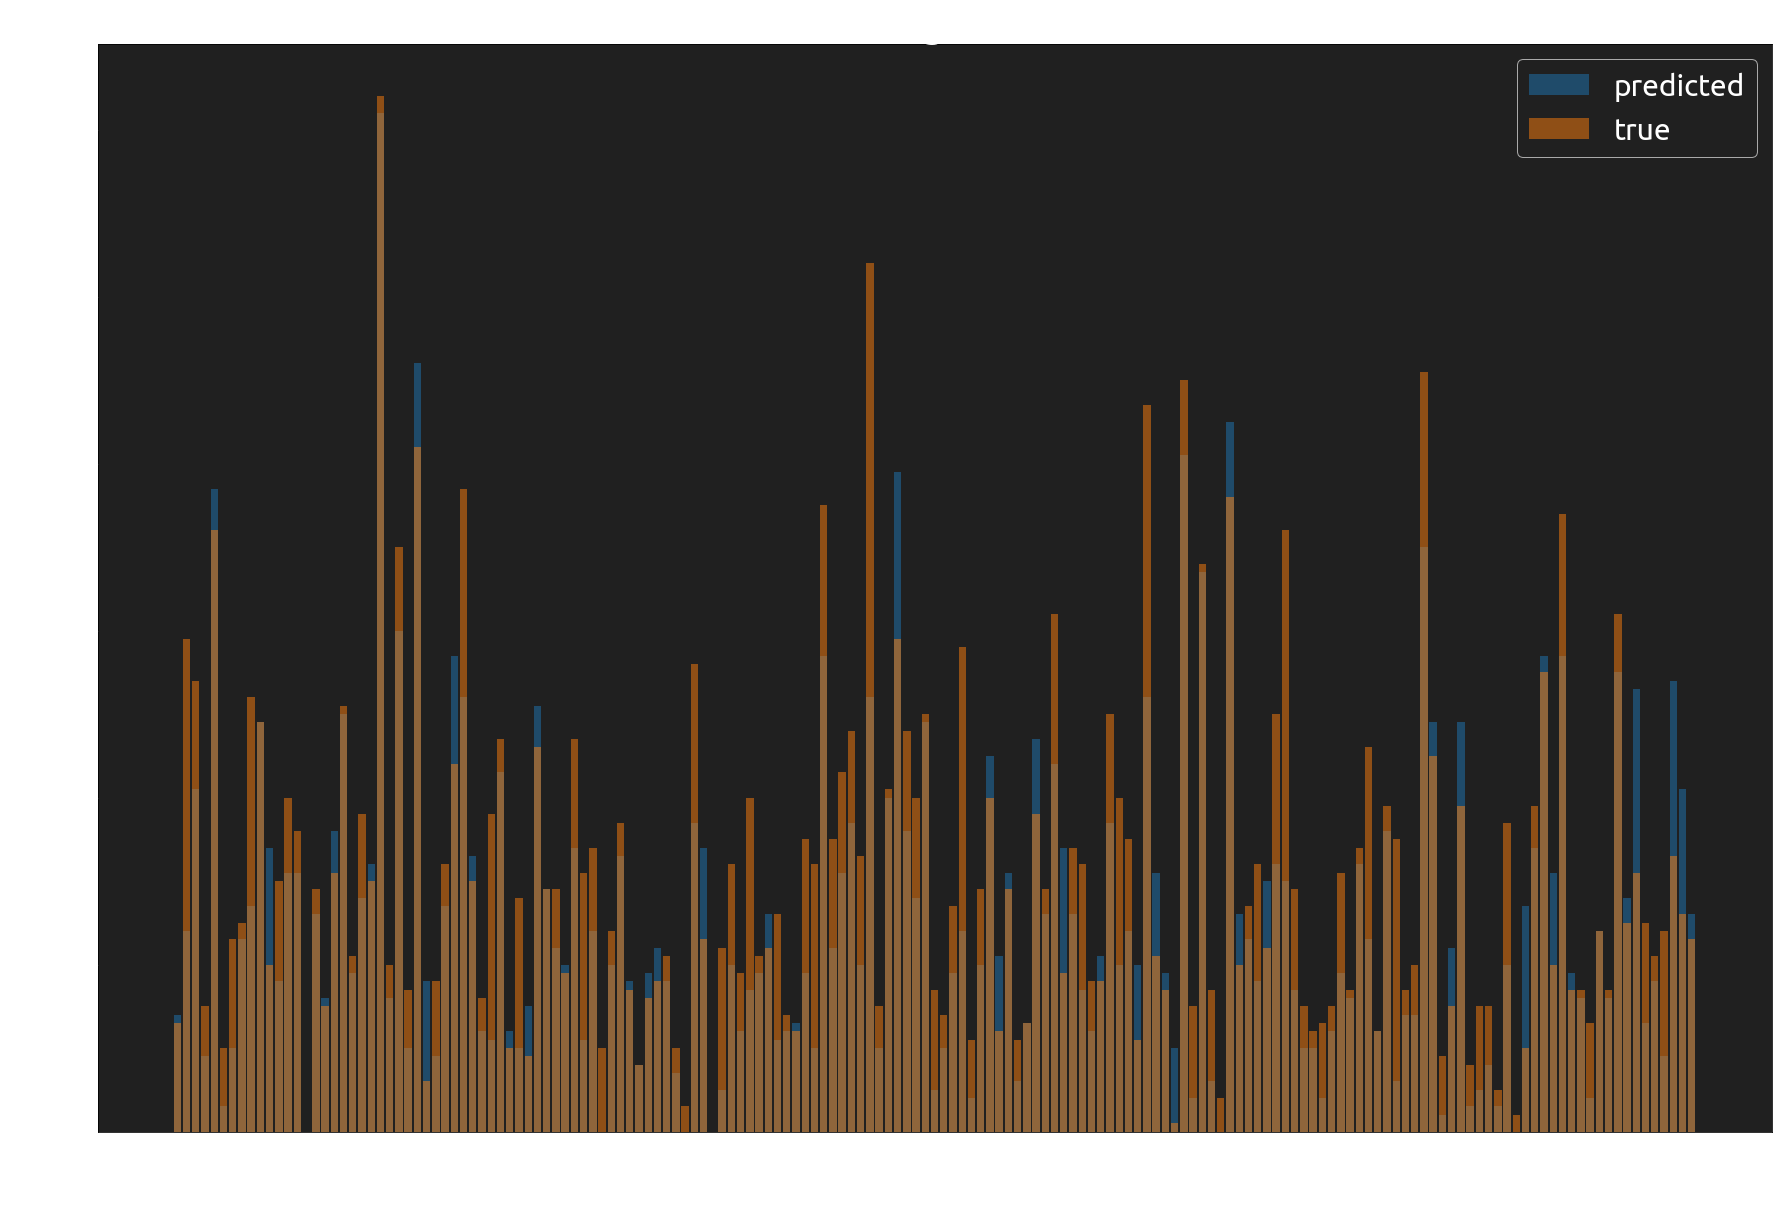

In [33]:
def plot_distribution(df_1, df_2):
    plt.figure(figsize=(30,20))
    n_min = 166
    freq_true = df_1[df_1['ID'] < n_min].groupby(['ID']).size()
    freq_pred = df_2[df_2['ID'] < n_min].groupby(['ID']).size()
    plt.bar(freq_pred.index, freq_pred, label='predicted', alpha=0.5)
    plt.bar(freq_true.index, freq_true, label='true', alpha=0.5)
    plt.title('Neuron Firing Distribution', fontsize=40)
    plt.legend(fontsize=30)
    plt.xlabel('Neuron ID (n)', fontsize=30)
    plt.ylabel('Count (N)', fontsize=30)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.show()


plot_distribution(test_data, df_pred)
# plt.savefig("id_interval_dist.png", dpi=300)

In [ ]:
len_pred = len(df_true)
# len_pred = 1000
plt.figure(figsize=(40,40))
plt.title('Pixel / Spike Raster', size=50)
plt.xlabel('Time')
plt.ylabel('Neuron ID')
plt.scatter(test_data['Time'], test_data['ID'], alpha=0.6, label='true', marker='o')
plt.scatter(df_pred['Time'], df_pred['ID'], alpha=0.6, label='predicted', marker='x')
plt.legend(fontsize=50)